In [2]:
#import packages
import pandas as pd
import numpy as np
import keras 
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score, make_scorer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
from keras.layers import LeakyReLU
LeakyReLU = LeakyReLU(alpha=0.1)
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
from sklearn.dummy import DummyClassifier

In [3]:
#import data and remove redundant columns
df_metrics = pd.read_csv('Data/metrics_corr.csv')
kl_list = [col for col in df_metrics.columns if col.endswith('_kl')]
df_metrics.drop(kl_list, axis=1, inplace=True)

In [5]:
#classify age
df_metrics.loc[(df_metrics['DoB']>1971) & (df_metrics['DoB']<=1983), 'age_class'] = 0
df_metrics.loc[(df_metrics['DoB']>1983) & (df_metrics['DoB']<=1994), 'age_class'] = 1
df_metrics.loc[(df_metrics['DoB']>1994) & (df_metrics['DoB']<=2000), 'age_class'] = 2
df_metrics.loc[(df_metrics['DoB']>2000) & (df_metrics['DoB']<=2011), 'age_class'] = 3

df_metrics['age_class'] = pd.to_numeric(df_metrics['age_class'], downcast = 'integer')
df_metrics = df_metrics[df_metrics.age_class.isnull() == False]

In [7]:
#categorize gender
le = LabelEncoder()
df_metrics['age_var'] = le.fit_transform(df_metrics['age_class'])
df_metrics['gender_var'] = le.fit_transform(df_metrics['Gender'])

In [8]:
#create lists that store column names for each saliency map

aim_list = [col for col in df_metrics.columns if col.startswith('aim_')]
rare_list = [col for col in df_metrics.columns if col.startswith('rare_')]
qss_list = [col for col in df_metrics.columns if col.startswith('qss_')]
lds_list = [col for col in df_metrics.columns if col.startswith('lds_')]
imsig_list = [col for col in df_metrics.columns if col.startswith('imsig_')]
ikn_list = [col for col in df_metrics.columns if col.startswith('ikn_')]
gbvs_list = [col for col in df_metrics.columns if col.startswith('gbvs_')]
gaus_list = [col for col in df_metrics.columns if col.startswith('gaus_')]
fes_list = [col for col in df_metrics.columns if col.startswith('fes_')]
dva_list = [col for col in df_metrics.columns if col.startswith('dva_')]
cvs_list = [col for col in df_metrics.columns if col.startswith('cvs_')]
cas_list = [col for col in df_metrics.columns if col.startswith('cas_')]
dgi_list = [col for col in df_metrics.columns if col.startswith('dgi_')]
dgii_list = [col for col in df_metrics.columns if col.startswith('dgii_')]
dgiie_list = [col for col in df_metrics.columns if col.startswith('dgiie_')]
icf_list = [col for col in df_metrics.columns if col.startswith('icf_')]
all_pred = icf_list + dgiie_list + dgii_list + dgi_list + cas_list + cvs_list + dva_list + fes_list + gbvs_list + ikn_list + imsig_list + lds_list + qss_list + rare_list + aim_list
d_aim_list = [col for col in df_metrics.columns if col.startswith('d_aim_')]

In [9]:
len(all_pred)

84

In [10]:
df_metrics.head()

,Unnamed: 0,id,fixations,fixmap,aim_nss,aim_auc,aim_ig,aim_cc,aim_sauc,aim_sim,rare_nss,rare_auc,rare_ig,rare_cc,rare_sauc,rare_sim,qss_nss,qss_auc,qss_ig,qss_cc,qss_sauc,qss_sim,lds_nss,lds_auc,lds_ig,lds_cc,lds_sauc,lds_sim,imsig_nss,imsig_auc,imsig_ig,imsig_cc,imsig_sauc,imsig_sim,gbvs_nss,gbvs_auc,gbvs_ig,gbvs_cc,gbvs_sauc,gbvs_sim,gauss_nss,gauss_auc,gauss_ig,gauss_cc,gauss_sauc,gauss_sim,fes_nss,fes_auc,fes_ig,fes_cc,fes_sauc,fes_sim,dva_nss,dva_auc,dva_ig,dva_cc,dva_sauc,dva_sim,cvs_nss,cvs_auc,cvs_ig,cvs_cc,cvs_sauc,cvs_sim,cas_nss,cas_auc,cas_ig,cas_cc,cas_sauc,cas_sim,dgi_nss,dgi_auc,dgi_ig,dgi_cc,dgi_sauc,dgi_sim,dgiie_nss,dgiie_auc,dgiie_ig,dgiie_cc,dgiie_sauc,dgiie_sim,dgii_nss,dgii_auc,dgii_ig,dgii_cc,dgii_sauc,dgii_sim,icf_nss,icf_auc,icf_ig,icf_cc,icf_sauc,icf_sim,DoB,Gender,age_class,age_var,gender_var
0,0,2.021070e+14,"[[288.8, 199.7], [1292.7, 915.9], [354.9, 946....",[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,-0.173250,0.411120,-2.305416,-0.003296,0.422562,0.000405,-0.068369,0.534746,-2.370930,-0.001242,0.473930,0.000409,0.265845,0.619417,-2.088616,0.005430,0.561867,0.000496,0.034678,0.459067,-2.874031,0.000726,0.422175,0.000450,0.192551,0.566724,-2.148197,0.004010,0.509269,0.000471,0.021620,0.528534,-2.381335,0.000444,0.424229,0.000437,0.002620,0.660138,-3.828059,0.000004,0.436100,0.000430,0.049463,0.341909,-3.104079,0.001031,0.423405,0.000460,-0.054976,0.519950,-2.373077,-0.001234,0.485100,0.000403,-0.032496,0.340028,-3.536221,-0.000658,0.351384,0.000398,-0.010765,0.511411,-2.260876,-0.000151,0.450289,0.000428,-0.070008,0.439027,-2.251289,-0.001458,0.396339,0.000418,-0.070008,0.439027,-2.251289,-0.001458,0.396339,0.000418,-0.070008,0.439027,-2.251289,-0.001458,0.396339,0.000418,0.114301,0.507494,-2.188486,0.002919,0.448937,0.000436,1974,MALE,0.0,0,1
1,1,2.021070e+14,"[[891.4, 672.8], [1223.4, 744.5], [956.8, 167....",[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,0.224671,0.538412,-2.087863,0.004922,0.560382,0.000518,0.653525,0.666648,-1.880576,0.013930,0.609916,0.000726,0.130715,0.554148,-2.159101,0.002810,0.502644,0.000514,0.336710,0.562397,-2.283954,0.007330,0.541136,0.000693,0.316649,0.624198,-2.012104,0.006909,0.570362,0.000552,0.470892,0.646396,-1.998717,0.010346,0.577086,0.000649,0.070961,0.303732,-3.143107,0.001537,0.553970,0.000567,0.412778,0.484085,-2.451170,0.009019,0.511663,0.000755,0.210373,0.570619,-2.095303,0.004617,0.554098,0.000584,0.392331,0.461695,-2.707262,0.008586,0.598408,0.000921,0.512079,0.644688,-1.937374,0.011140,0.589819,0.000622,-0.005878,0.477098,-2.172694,-0.000254,0.423363,0.000476,-0.005878,0.477098,-2.172694,-0.000254,0.423363,0.000476,-0.005878,0.477098,-2.172694,-0.000254,0.423363,0.000476,0.420799,0.630459,-2.100955,0.009112,0.568972,0.000498,1999,FEMALE,2.0,2,0
2,2,2.021070e+14,"[[848.5, 851.7], [1400.1, 871.9], [1472.3, 295...",[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,0.686180,0.686619,-2.062538,0.014210,0.714630,0.000539,0.563947,0.671699,-2.040720,0.011478,0.615217,0.000624,0.399106,0.572741,-2.229954,0.008316,0.526731,0.000532,0.146272,0.576055,-2.452639,0.003002,0.558025,0.000514,0.265811,0.599793,-2.210012,0.005515,0.554732,0.000486,0.292491,0.604644,-2.180548,0.006040,0.516587,0.000525,-0.312802,0.457577,-4.075178,-0.006476,0.461977,0.000075,0.124923,0.350089,-2.576648,0.002628,0.558574,0.000507,0.601499,0.615484,-2.043944,0.012462,0.608590,0.000702,-0.200191,0.424040,-3.434880,-0.004122,0.475200,0.000228,0.428949,0.625828,-2.118001,0.008767,0.576280,0.000537,0.310498,0.595997,-2.198153,0.006332,0.554610,0.000482,0.310498,0.595997,-2.198153,0.006332,0.554610,0.000482,0.310498,0.595997,-2.198153,0.006332,0.554610,0.000482,0.252469,0.566422,-2.277651,0.005538,0.504005,0.000442,1978,MALE,0.0,0,1
3,3,2.021070e+14,"[[908.6, 304.9], [238.5, 226.8], [1354.1, 827....",[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0....,0.343402,0.564721,-2.492345,0.006796,0.584228,0.000482,0.124839,0.608373,-2.529963,0.002413,0.540472,0.000471,0.469243,0.681522,-2.34374

In [12]:
#read in feature selection info
df_age_cols = pd.read_csv('Data/age_selectk.csv')
df_sex_cols = pd.read_csv('Data/sex_selectk.csv')

In [13]:
df_age_cols.head()

,Unnamed: 0,col_name,fs_score,map,avg_fs_score
0,66,qss_nss,1.948164,qss,1.940919
1,67,qss_auc,2.069283,qss,1.940919
2,68,qss_ig,1.968535,qss,1.940919
3,69,qss_cc,2.299368,qss,1.940919
4,70,qss_sauc,2.042680,qss,1.940919


## Age CNN with 15 variables 

In [16]:
#select top 15 age columns from feature selection
temp = df_age_cols.nlargest(15,'fs_score')
cols = temp['col_name'].tolist()

In [17]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.age_class, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [18]:
#define model
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#cross validate model on training data
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

#predict test data and print classification results
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 23.41% (7.01%)
              precision    recall  f1-score   support

         0.0       0.17      0.33      0.22        21
         1.0       0.38      0.24      0.30        33
         2.0       0.34      0.48      0.40        31
         3.0       0.00      0.00      0.00        22

    accuracy                           0.28       107
   macro avg       0.22      0.26      0.23       107
weighted avg       0.25      0.28      0.25       107

Model F1 Score  0.2803738317757009


## Same data different CNN architecture - 3 hidden layers

In [52]:
#repeat process, test new model architecture
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(10, input_dim=15, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 23.83% (7.86%)
              precision    recall  f1-score   support

         0.0       0.23      0.48      0.31        21
         1.0       0.35      0.24      0.29        33
         2.0       0.31      0.39      0.34        31
         3.0       0.00      0.00      0.00        22

    accuracy                           0.28       107
   macro avg       0.22      0.28      0.23       107
weighted avg       0.24      0.28      0.25       107

Model F1 Score  0.2803738317757009


## age cnn with features from logistic regression

In [18]:
#select features used in logistic regression age model
temp = df_age_cols.nlargest(50,'fs_score')
cols = temp['col_name'].tolist()

X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.age_class, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

feat_names = ['3', '4', '12', '16', '17', '20', '34', '49']
X_age = np.take(X_train, feat_names, axis = 1)
X_test = np.take(X_test, feat_names, axis = 1)

In [32]:
#test model with this data and print results
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=8, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_age, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_age, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 26.24% (6.04%)
              precision    recall  f1-score   support

         0.0       0.26      0.48      0.34        21
         1.0       0.19      0.09      0.12        33
         2.0       0.38      0.65      0.48        31
         3.0       1.00      0.05      0.09        22

    accuracy                           0.32       107
   macro avg       0.46      0.31      0.26       107
weighted avg       0.43      0.32      0.26       107

Model F1 Score  0.3177570093457944


## hypertune parameters

In [20]:
score_acc = make_scorer(accuracy_score)

In [48]:
#define function for input to bayesian optimisation function

def nn_cl_bo(activation, optimizer, learning_rate,  batch_size, epochs): #,normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    #neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    #define network architecture
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(15, input_dim=8, activation=activation))
        nn.add(Dense(15, activation=activation))
        nn.add(Dense(4, activation='softmax'))
        nn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,verbose=0)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=141)
    score = cross_val_score(nn, X_age, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [49]:
#parameters for optimisation
params_nn ={
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 0.5),
    'batch_size':(20, 100),
    'epochs':(5, 100)
}
# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=150)

In [50]:
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... | optimizer |
-------------------------------------------------------------------------------------
|  1        |  0.2388   |  8.177    |  40.64    |  88.38    |  0.3721   |  4.887    |
|  2        |  0.2717   |  4.655    |  96.17    |  91.8     |  0.04831  |  5.476    |
|  3        |  0.2904   |  1.023    |  71.27    |  12.58    |  0.1237   |  2.702    |
|  4        |  0.2833   |  2.131    |  99.87    |  41.99    |  0.3647   |  3.162    |
|  5        |  0.2411   |  4.292    |  63.62    |  46.12    |  0.299    |  0.7348   |
|  6        |  0.262    |  7.75     |  44.64    |  51.24    |  0.1129   |  4.341    |
|  7        |  0.2435   |  3.072    |  59.57    |  34.19    |  0.2146   |  5.321    |
|  8        |  0.2787   |  0.3685   |  59.99    |  82.21    |  0.265    |  3.021    |
|  9        |  0.2646   |  6.648    |  79.43    |  88.68    |  0.4914   |  1.539    |
|  10       |  0.2877   |  0.8396   |  31.66    |  44.

In [51]:
#extract max parameters
params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

{'activation': 'sigmoid',
 'batch_size': 56.850471617136726,
 'epochs': 28.642656540450194,
 'learning_rate': 0.042162474282075285,
 'optimizer': 1.5060934987503525}

## Age data with hypertuned parameters

In [54]:
#create model with tuned paramters
def baseline_model():
    opt = Adam(lr = 0.04)
    model = Sequential()
    model.add(Dense(15, input_dim=8, activation='sigmoid'))
    model.add(Dense(15, activation='sigmoid'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=29, batch_size=56, verbose=0)
kfold = StratifiedKFold(n_splits=20, shuffle=True)
results = cross_val_score(estimator, X_age, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_age, y_train, epochs=29, batch_size=56, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 28.92% (10.77%)
              precision    recall  f1-score   support

         0.0       0.25      0.43      0.32        21
         1.0       0.30      0.42      0.35        33
         2.0       0.53      0.29      0.38        31
         3.0       0.43      0.14      0.21        22

    accuracy                           0.33       107
   macro avg       0.38      0.32      0.31       107
weighted avg       0.38      0.33      0.32       107

Model F1 Score  0.32710280373831774


# SEX

## Sex CNN with 15 variables

In [55]:
#extract top 15 features for sex after feature selection
temp = df_sex_cols.nlargest(15,'fs_score')
cols_sex = temp['col_name'].tolist()

In [57]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols_sex], df_metrics.gender_var, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [59]:
#define initial model & classify test data
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 49.17% (6.50%)
              precision    recall  f1-score   support

           0       0.49      0.32      0.39        53
           1       0.50      0.67      0.57        54

    accuracy                           0.50       107
   macro avg       0.49      0.49      0.48       107
weighted avg       0.49      0.50      0.48       107

Model F1 Score  0.4953271028037383


## Same data different architecture - 3 hidden layers

In [60]:
#use same data with different network architecture
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(15, input_dim=15, activation='relu'))
    model.add(Dense(10, input_dim=15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 48.00% (6.29%)
              precision    recall  f1-score   support

           0       0.54      0.26      0.35        53
           1       0.52      0.78      0.62        54

    accuracy                           0.52       107
   macro avg       0.53      0.52      0.49       107
weighted avg       0.53      0.52      0.49       107

Model F1 Score  0.5233644859813084


## Sex data with features from logistic regression

In [67]:
#test network using same data as was selected for logistic regression
temp = df_sex_cols.nlargest(50,'fs_score')
cols_sex = temp['col_name'].tolist()

X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols_sex], df_metrics.gender_var, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

feat_names = ['0', '3', '20', '32', '33', '36', '38']
X_sex = np.take(X_train, feat_names, axis = 1)
X_test = np.take(X_test, feat_names, axis = 1)

In [63]:
#use this data in network with 1 hidden layer & classify test data
def baseline_model():
    model = Sequential()
    model.add(Dense(15, input_dim=7, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_sex, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_sex, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 49.45% (6.69%)
              precision    recall  f1-score   support

           0       0.51      0.36      0.42        53
           1       0.51      0.67      0.58        54

    accuracy                           0.51       107
   macro avg       0.51      0.51      0.50       107
weighted avg       0.51      0.51      0.50       107

Model F1 Score  0.514018691588785


## Same data with 3 hidden layers

In [69]:
#use same data in network with 3 hidden layers
def baseline_model():
    model = Sequential()
    model.add(Dense(7, input_dim=7, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_sex, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_sex, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 52.21% (6.45%)
              precision    recall  f1-score   support

           0       0.50      0.23      0.31        53
           1       0.51      0.78      0.61        54

    accuracy                           0.50       107
   macro avg       0.50      0.50      0.46       107
weighted avg       0.50      0.50      0.46       107

Model F1 Score  0.5046728971962616


## Sex data with top 30 features

In [70]:
#extract top 30 features ranked by anova correlation
temp = df_sex_cols.nlargest(30,'fs_score')
cols_sex = temp['col_name'].tolist()

#split data into train and test using only these 30 features
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols_sex], df_metrics.gender_var, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [71]:
#create model with 1 hidden layer using this data to train
def baseline_model():
    model = Sequential()
    model.add(Dense(30, input_dim=30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

#predict test data
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 49.22% (7.61%)
              precision    recall  f1-score   support

           0       0.46      0.43      0.45        53
           1       0.47      0.50      0.49        54

    accuracy                           0.47       107
   macro avg       0.47      0.47      0.47       107
weighted avg       0.47      0.47      0.47       107

Model F1 Score  0.4672897196261683


## same data 3 hidden layers

In [73]:
#model with 3 hidden layers & print results
def baseline_model():
    model = Sequential()
    model.add(Dense(30, input_dim=30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 45.87% (5.20%)
              precision    recall  f1-score   support

           0       0.49      0.38      0.43        53
           1       0.50      0.61      0.55        54

    accuracy                           0.50       107
   macro avg       0.49      0.49      0.49       107
weighted avg       0.49      0.50      0.49       107

Model F1 Score  0.4953271028037383


## Hypertune parameters

In [124]:
#extract top 50 features ranked by anova correlation
temp = df_sex_cols.nlargest(50,'fs_score')
cols_sex = temp['col_name'].tolist()

#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols_sex], df_metrics.gender_var, test_size=0.2,random_state=131) # 70% training and 30% test
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#feature names used to train logistic regression models in sex, filter to only include these columns
feat_names = ['0', '3', '20', '32', '33', '36', '38']
X_sex = np.take(X_train, feat_names, axis = 1)
X_test = np.take(X_test, feat_names, axis = 1)

In [76]:
#define function for input to bayesian optimisation function
def nn_cl_bo(activation, optimizer, learning_rate,  batch_size, epochs): #,normalization, dropout, dropout_rate):
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    #neurons = round(neurons)
    activation = activationL[round(activation)]
    batch_size = round(batch_size)
    epochs = round(epochs)
    #define network - 3 hidden layers is best
    def nn_cl_fun():
        opt = Adam(lr = learning_rate)
        nn = Sequential()
        nn.add(Dense(7, input_dim=7, activation=activation))
        nn.add(Dense(7, activation=activation))
        nn.add(Dense(7, activation=activation))
        nn.add(Dense(4, activation=activation))
        nn.add(Dense(1, activation='sigmoid'))
        nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return nn
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=0, patience=20)
    nn = KerasClassifier(build_fn=nn_cl_fun, epochs=epochs, batch_size=batch_size,verbose=0)
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=141)
    score = cross_val_score(nn, X_sex, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [77]:
#define parameters for optimisation
params_nn ={
    'activation':(0, 9),
    'optimizer':(0,7),
    'learning_rate':(0.01, 0.5),
    'batch_size':(20, 100),
    'epochs':(5, 100)
}

# Run Bayesian Optimization
nn_bo = BayesianOptimization(nn_cl_bo, params_nn, random_state=150)

In [78]:
# Run Bayesian Optimization
nn_bo.maximize(init_points=25, n_iter=4)

|   iter    |  target   | activa... | batch_... |  epochs   | learni... | optimizer |
-------------------------------------------------------------------------------------
|  1        |  0.5317   |  8.177    |  40.64    |  88.38    |  0.3721   |  4.887    |
|  2        |  0.5202   |  4.655    |  96.17    |  91.8     |  0.04831  |  5.476    |
|  3        |  0.5525   |  1.023    |  71.27    |  12.58    |  0.1237   |  2.702    |
|  4        |  0.5457   |  2.131    |  99.87    |  41.99    |  0.3647   |  3.162    |
|  5        |  0.5339   |  4.292    |  63.62    |  46.12    |  0.299    |  0.7348   |
|  6        |  0.5245   |  7.75     |  44.64    |  51.24    |  0.1129   |  4.341    |
|  7        |  0.5297   |  3.072    |  59.57    |  34.19    |  0.2146   |  5.321    |
|  8        |  0.548    |  0.3685   |  59.99    |  82.21    |  0.265    |  3.021    |
|  9        |  0.452    |  6.648    |  79.43    |  88.68    |  0.4914   |  1.539    |
|  10       |  0.5503   |  0.8396   |  31.66    |  44.

In [79]:
#extract max parameters
params_nn_ = nn_bo.max['params']
activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
               'elu', 'exponential', LeakyReLU,'relu']
params_nn_['activation'] = activationL[round(params_nn_['activation'])]
params_nn_

{'activation': <keras.layers.advanced_activations.LeakyReLU at 0x25cc84880a0>,
 'batch_size': 29.52797964396342,
 'epochs': 8.326870064552317,
 'learning_rate': 0.09900103326155506,
 'optimizer': 6.80891781550587}

## Sex data with hypertuned parameters

In [88]:
#run model with tuned parameters
def baseline_model():
    opt = Adam(lr = 0.099)
    model = Sequential()
    model.add(Dense(7, input_dim=7, activation=LeakyReLU))
    model.add(Dense(7, activation=LeakyReLU))
    #model.add(Dropout(0.05, seed=123))
    model.add(Dense(7, activation=LeakyReLU))
    model.add(Dense(4, activation=LeakyReLU))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=8, batch_size=30, verbose=0)
kfold = StratifiedKFold(n_splits=20, shuffle=True)
results = cross_val_score(estimator, X_sex, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
estimator.fit(X_sex, y_train, epochs=8, batch_size=30, verbose=0)
pred = estimator.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 55.18% (9.12%)
              precision    recall  f1-score   support

           0       0.52      0.64      0.58        53
           1       0.55      0.43      0.48        54

    accuracy                           0.53       107
   macro avg       0.54      0.53      0.53       107
weighted avg       0.54      0.53      0.53       107

Model F1 Score  0.5327102803738317


## train test accuracy chart 

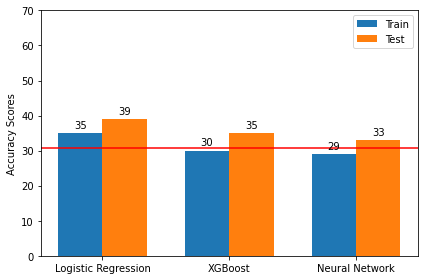

In [8]:
#create train test accuracy chart for age
width = 0.35  # the width of the bars

#train test accuracy for each age model
train = [35,30,29]
test = [39,35,33]
#labels for 
labels = ['Logistic Regression','XGBoost','Neural Network']

#create bar chart
x = np.arange(len(labels))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train, width, label='Train')
rects2 = ax.bar(x + width/2, test, width, label='Test')
ax.set_ylim([0, 70])

ax.set_ylabel('Accuracy Scores')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.axhline(y = 30.8, color = 'r', linestyle = '-')


#plt.title('Age: Train/Test Accuracy per Classification Model')
#ax.set_xlabel('Classification Model')

fig.tight_layout()

plt.savefig('C:\\Users\\njeri\\Documents\\Masters\\Thesis\\Draft\\Images\\age accuracy ppt.png');
plt.show()


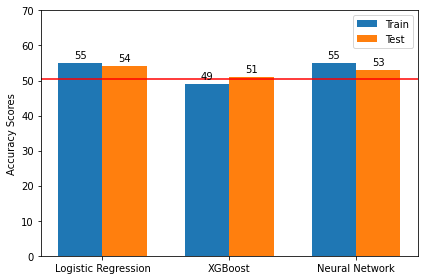

In [9]:
#create train test accuracy chart for sex
width = 0.35  # the width of the bars

#train test accuracy for each sex model
train = [55,49,55]
test = [54,51,53]
labels = ['Logistic Regression','XGBoost','Neural Network']

#create bar chart
x = np.arange(len(labels))
fig, ax = plt.subplots()
ax.set_ylim([0, 70])
rects1 = ax.bar(x - width/2, train, width, label='Train')
rects2 = ax.bar(x + width/2, test, width, label='Test')

ax.set_ylabel('Accuracy Scores')
#plt.title('Gender: Train/Test Accuracy per Classification Model')
#ax.set_xlabel('Classification Model')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.axhline(y = 50.4, color = 'r', linestyle = '-')

fig.tight_layout()

plt.savefig('C:\\Users\\njeri\\Documents\\Masters\\Thesis\\Draft\\Images\\sex accuracy ppt.png')
plt.show();